<a href="https://colab.research.google.com/github/Lambru99/CPSProject2/blob/main/cyber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Monta Google Drive per accedere ai file
from google.colab import drive
drive.mount('/content/drive')

# Importa le librerie necessarie
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# Carica il dataset da Google Drive
file_path = "/content/drive/MyDrive/cyber/definitivo.csv"
df = pd.read_csv(file_path)

# Rimuovi spazi bianchi dai nomi delle colonne
df.columns = df.columns.str.strip()

# Converti la colonna 'Normal/Attack' in numeri
df['Normal/Attack'] = df['Normal/Attack'].map({'Normal': 0, 'Attack': 1})

# Rimuovi la colonna 'Timestamp' poiché non è necessaria per il rilevamento delle anomalie
df = df.drop(columns=['Timestamp'])

# Rimuovi tutte le righe che contengono almeno un valore NaN
df.dropna(inplace=True)

# Dividi il dataset in features (X) e target (y)
X = df.drop(columns=['Normal/Attack'])
y = df['Normal/Attack']

# Standardizza le features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividi il dataset in training set e test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Reshape dei dati di input per includere le informazioni temporali
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Crea il modello
def create_lstm_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model
# Imposta la forma dei dati correttamente per l'input del modello LSTM
input_shape = (X_train.shape[1], 1)

# Crea il modello
model = create_lstm_model(input_shape)

# Fai il fit del modello
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

# Valuta il modello sul set di test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)



Mounted at /content/drive
Epoch 1/10
6308/6308 [==============================] - 70s 10ms/step - loss: 0.0686 - accuracy: 0.9864 - val_loss: 0.0431 - val_accuracy: 0.9906
Epoch 2/10
6308/6308 [==============================] - 60s 10ms/step - loss: 0.0321 - accuracy: 0.9923 - val_loss: 0.0243 - val_accuracy: 0.9931
Epoch 3/10
6308/6308 [==============================] - 64s 10ms/step - loss: 0.0200 - accuracy: 0.9949 - val_loss: 0.0159 - val_accuracy: 0.9958
Epoch 4/10
6308/6308 [==============================] - 58s 9ms/step - loss: 0.0164 - accuracy: 0.9955 - val_loss: 0.0141 - val_accuracy: 0.9957
Epoch 5/10
6308/6308 [==============================] - 59s 9ms/step - loss: 0.0138 - accuracy: 0.9960 - val_loss: 0.0120 - val_accuracy: 0.9960
Epoch 6/10
6308/6308 [==============================] - 58s 9ms/step - loss: 0.0124 - accuracy: 0.9962 - val_loss: 0.0110 - val_accuracy: 0.9966
Epoch 7/10
6308/6308 [==============================] - 60s 10ms/step - loss: 0.0108 - accuracy: 0.99

In [2]:
# Effettua previsioni sul set di test
y_pred = model.predict(X_test)

# Imposta una soglia per classificare le previsioni come anomalie
threshold = 0.5
# Confronta le previsioni con la soglia per identificare gli esempi anomali
y_pred_anomalies = (y_pred > threshold).astype(int)

13516/13516 [==============================] - 48s 3ms/step



# Analyzing the model




In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

## Classification Report


**Precision**: Represents the proportion of instances classified as positive that are actually positive. In other words, it is the model's ability to not mislabel negative instances as positive. For class 0 (non-anomaly), precision is 100%, meaning all instances classified as non-anomalies are actually non-anomalies. For class 1 (anomaly), precision is 98%, indicating that 2% of instances classified as anomalies might be false positives.

**Recall**: Represents the proportion of total positive instances that were correctly identified by the model. In other words, it is the model's ability to find all positive instances. For class 0, recall is 100%, indicating that all non-anomaly instances were correctly identified. For class 1, recall is 95%, meaning that 5% of anomaly instances might not have been detected by the model.

**F1-score**: It is a weighted average of precision and recall. It represents the balance between precision and recall. A high F1-score indicates a good balance between precision and recall.

**Support**: Represents the number of instances in each class in the test dataset.

**Accuracy**: Represents the proportion of correct predictions out of the total predictions made by the model. In your case, accuracy is 100%, meaning all predictions made by the model are correct in the test dataset.

In [4]:
# Valuta le prestazioni del modello
print(classification_report(y_test, y_pred_anomalies))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    416373
         1.0       0.98      0.94      0.96     16132

    accuracy                           1.00    432505
   macro avg       0.99      0.97      0.98    432505
weighted avg       1.00      1.00      1.00    432505



## Learning Curves
The learning curve can provide valuable insights into the performance of a machine learning model during training.
As we can see from these two learning curves that analyze both loss and accuracy, the model seems to be learning effectively and generalizing well to unseen data.

* Both the training and validation loss curves show a clear downward trend, indicating that the model is consistently improving its ability to correctly classify instances.
* The gap between the training and validation curves remains small throughout the training process, suggesting that the model is not significantly overfitting the training data. This is crucial for good generalization to unseen data.
* Both training and validation accuracy curves show an upward trend, reaching high final values. This implies that the model is correctly classifying both training and unseen data with a high degree of accuracy.

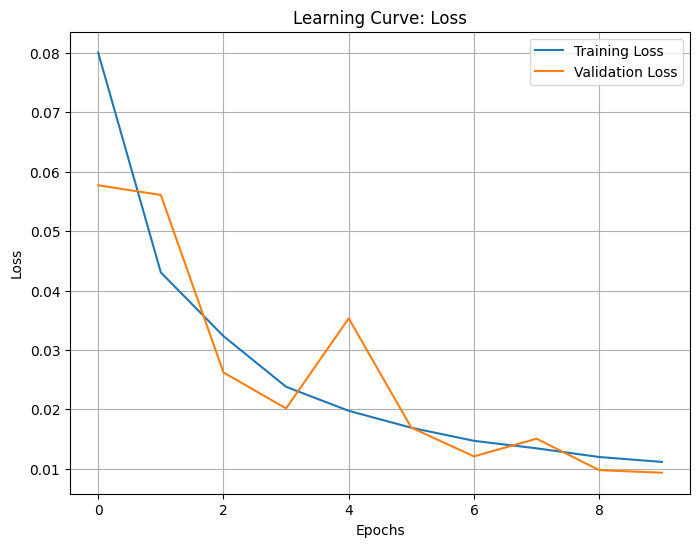

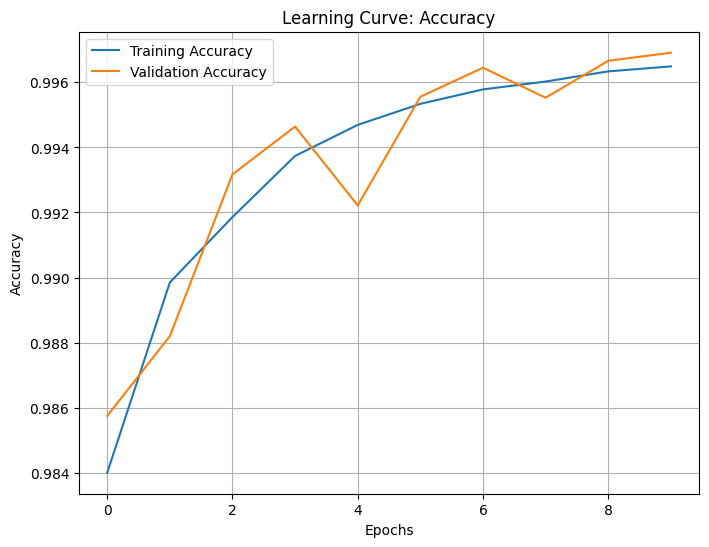

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


The confusion matrix helps visualize true positives, true negatives, false positives, and false negatives.

As we already discussed for the curves, this confusion matrix further strengthens the case that the model is a highly effective anomaly detector.

* Just like the low training and validation loss in the curves, the TPR of 0.98 in the confusion matrix confirms the model's ability to correctly identify real attacks. This signifies minimal instances slipping through the cracks.
* The TNR of 1.00 echoes the small gap between curves, indicating excellent generalization. The model rarely misclassifies normal instances as attacks, minimizing false alarms.
* The precision of 0.98 for attacks reiterates the curves' suggestion of minimal overfitting. The model focuses on true positives, reducing noise and false positives.
* The recall of 0.98 for attacks aligns with the high validation accuracy, reflecting the model's ability to capture most attacks. Missed attacks are rare.
* With only 387 false positives, the confusion matrix emphasizes the curves' indication of minimal overfitting.

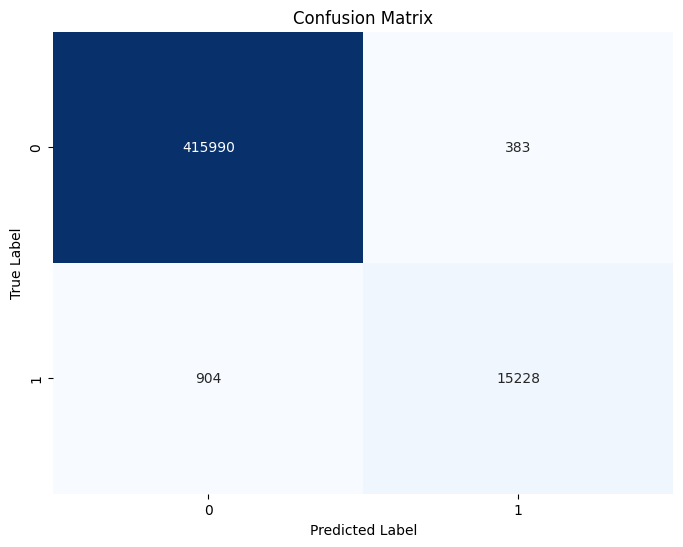

In [6]:
cm = confusion_matrix(y_test, y_pred_anomalies)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




The ROC curve illustrates the trade-off between sensitivity and specificity at various threshold settings. Based on the combination of all the analyses, it's likely that your model slightly prioritizes sensitivity, especially at stricter thresholds. However, it maintains a good overall balance between sensitivity and specificity across various thresholds.



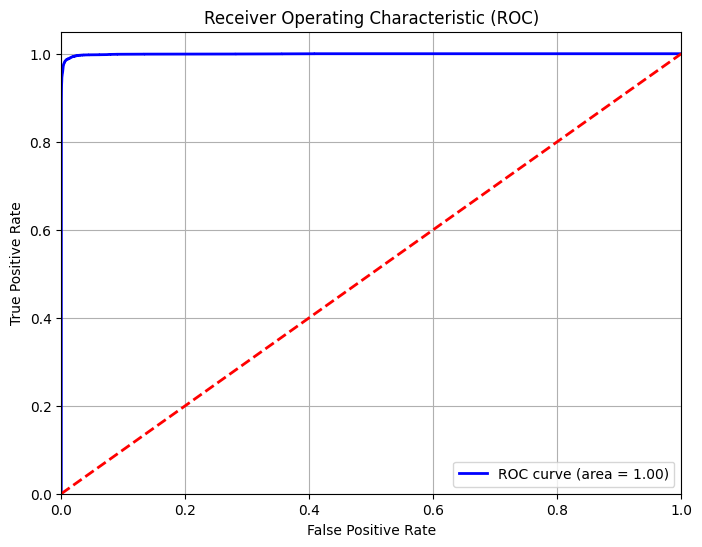

In [7]:
# Plotting ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

The precision-recall curve illustrates the trade-off between precision and recall. As we can see the curve starts very close to the top (representing perfect precision) and gradually decreases as recall increases. This means the model can achieve very high precision even when only a small portion of actual attacks are identified.

The decrease in precision as recall increases is relatively slow, indicating that the model maintains good precision even as it identifies more attacks. This is a positive sign, as it suggests the model does not generate a large number of false positives when trying to catch more attacks.





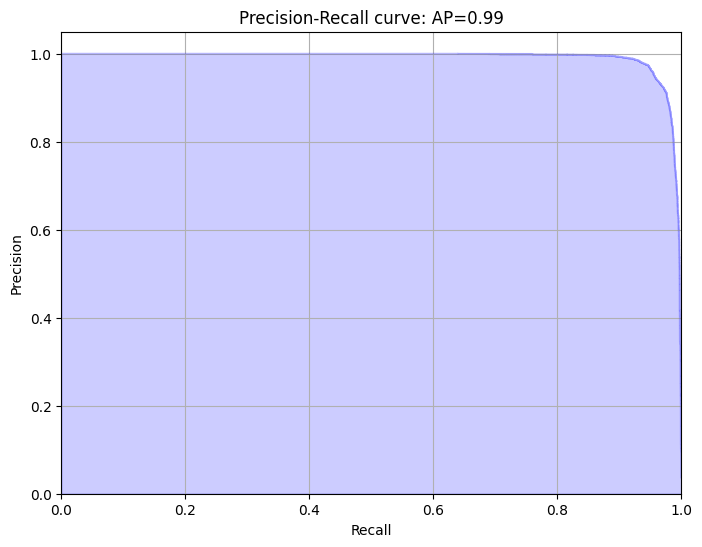

In [8]:
# Plotting Precision-Recall curve

precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.grid(True)
plt.show()


The histogram of predicted anomaly scores shows the distribution of anomaly scores across the test set. Basing on this histogram it seems like this model's predictions are indeed slightly skewed towards the attack class (higher values), consistent with what I mentioned earlier. Here's a more detailed analysis:

**Observations**:

* **Shape**: The histogram has a relatively smooth, unimodal distribution, as expected for a well-performing model.
* **Distribution**: The peak of the distribution leans slightly towards the right side, indicating that a larger portion of predictions fall into higher values, which represent predicted attacks. This aligns with the idea that the model prioritizes sensitivity to some extent, aiming to catch most attacks even if it means some false positives.
* **Outliers**: There are a few outliers on both ends of the histogram, but they are relatively infrequent. This suggests that most predictions are confident (closer to either 0 or 1), while a small number fall into the less confident range.

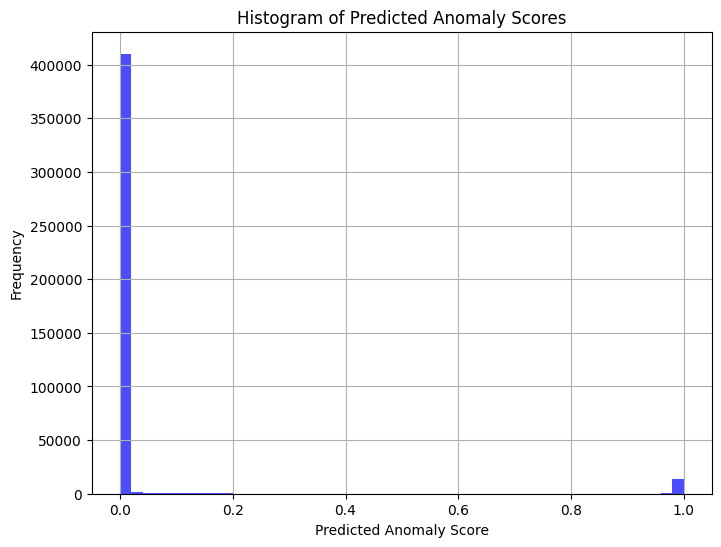

In [9]:
# Plotting Histogram of Predicted Anomaly Scores
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=50, color='blue', alpha=0.7)
plt.xlabel('Predicted Anomaly Score')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Anomaly Scores')
plt.grid(True)
plt.show()

# Attack model


It's important to clarify that the DAICS paper itself doesn't propose attacks against the anomaly detection model. Its focus is on improving the detection of actual anomalies, not exploring ways to bypass it.

However, the field of anomaly detection does consider potential attacks and vulnerabilities, so it's valuable to discuss them even if not directly addressed in the specific paper. Here are some general attack types relevant to anomaly detection models like DAICS:

Adversarial attacks: These involve crafting specific inputs that intentionally trigger false positives or negatives. In the context of ICSs, this could involve manipulating sensor data to appear normal while hiding malicious activity.

Data poisoning: Attackers inject malicious data into the training dataset to manipulate the model's behavior. This could be difficult for DAICS since it requires few data samples, but not impossible.

Model inversion: Attackers try to recover sensitive information from the model itself, potentially revealing normal behavior patterns and making it easier to craft attacks.

Evasion attacks: Attackers modify their actions to avoid detection by the model while still achieving their goals. This could involve mimicking normal behavior or exploiting specific weaknesses in the model's decision-making process.

Synergy attacks: Attackers combine multiple techniques, like data poisoning and evasion, to make their attacks more effective.

It's important to note that DAICS does incorporate some measures to mitigate these vulnerabilities, such as its focus on learning changes in behavior and its robustness to noise. However, no model is completely immune to attack, and ongoing research is crucial to staying ahead of potential threats.

If you're interested in learning more about specific attacks against anomaly detection models or the defense mechanisms employed by DAICS, feel free to ask!

In [10]:
import numpy as np

# Generate synthetic attacks by adding outliers to the test set
def add_outliers(X_test, outlier_ratio=1):
    num_outliers = int(len(X_test) * outlier_ratio)
    indices = np.random.choice(len(X_test), num_outliers, replace=False)
    X_test_outliers = X_test.copy()
    for idx in indices:
        # Add outliers by multiplying random noise to a random feature
        feature_idx = np.random.randint(0, X_test.shape[1])
        X_test_outliers[idx, feature_idx] *= np.random.uniform(5, 10)  # Add outlier by scaling
    return X_test_outliers

# Simulate attacks by adding outliers to the test set
X_test_attacked = add_outliers(X_test)

# Evaluate the model on attacked test set
test_loss_attacked, test_accuracy_attacked = model.evaluate(X_test_attacked, y_test)
print("Test Accuracy on Attacked Test Set:", test_accuracy_attacked)


13516/13516 [==============================] - 59s 4ms/step - loss: 0.1230 - accuracy: 0.9664
Test Accuracy on Attacked Test Set: 0.9663795828819275


In [11]:
# Generate synthetic attacks by adding malicious instances to the training set
def add_malicious_instances(X_train, y_train, malicious_ratio=1):
    num_malicious = int(len(X_train) * malicious_ratio)
    malicious_instances = np.random.rand(num_malicious, X_train.shape[1])  # Generate random malicious instances
    malicious_labels = np.ones(num_malicious)  # Assign malicious labels
    X_train_malicious = np.concatenate([X_train, malicious_instances])
    y_train_malicious = np.concatenate([y_train, malicious_labels])
    return X_train_malicious, y_train_malicious

# Simulate a data poisoning attack by adding malicious instances to the training set
X_train_poisoned, y_train_poisoned = add_malicious_instances(X_train, y_train)

# Train the model on the poisoned training set
poisoned_model = create_lstm_model(input_shape)
history_poisoned = poisoned_model.fit(X_train_poisoned, y_train_poisoned, epochs=1, batch_size=128, validation_split=0.2)

# Evaluate the poisoned model on the original test set
test_loss_poisoned, test_accuracy_poisoned = poisoned_model.evaluate(X_test, y_test)
print("Test Accuracy of Poisoned Model on Original Test Set:", test_accuracy_poisoned)


13516/13516 [==============================] - 78s 6ms/step - loss: 0.0306 - accuracy: 0.9925
Test Accuracy of Poisoned Model on Original Test Set: 0.9925480484962463


In [12]:
import numpy as np

# Function to generate adversarial examples using FGSM with NumPy
def fgsm_attack_numpy(model, X, y, epsilon=0.5):
    # Compute gradients of the loss with respect to the input data
    gradient = compute_gradient(model, X, y)

    # Compute the sign of the gradient
    sign_gradient = np.sign(gradient)

    # Generate perturbation
    perturbation = epsilon * sign_gradient

    # Create adversarial examples
    adversarial_X = X + perturbation.T  # Transpose perturbation to match the shape of X

    return adversarial_X

# Function to compute gradient of the loss with respect to the input data
def compute_gradient(model, X, y):
    # Forward pass
    logits = model.predict(X)

    # Convert y to NumPy array and reshape it
    y_array = np.array(y).reshape(-1, 1)

    # Compute loss gradient manually (assuming binary cross-entropy loss)
    error = logits - y_array
    gradient = X.T @ error / len(X)

    return gradient

# Generate adversarial examples using FGSM with NumPy
epsilon = 0.1  # Magnitude of perturbation
X_test_adv_numpy = fgsm_attack_numpy(model, X_test, np.array(y_test), epsilon)

# Evaluate the model on the adversarial examples
test_loss_adv_numpy, test_accuracy_adv_numpy = model.evaluate(X_test_adv_numpy, y_test)
print("Test Accuracy on Adversarial Examples (NumPy):", test_accuracy_adv_numpy)


13516/13516 [==============================] - 61s 5ms/step - loss: 0.0235 - accuracy: 0.9940
Test Accuracy on Adversarial Examples (NumPy): 0.9939538240432739


In [13]:
import numpy as np

# Importa le librerie necessarie
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Importa le librerie di Keras
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

# Crea il modello autoencoder LSTM
class LSTM_Autoencoder:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.autoencoder = self.build_autoencoder()

    def build_encoder(self):
        encoder = Sequential([
            LSTM(32, input_shape=self.input_shape, return_sequences=True),
            LSTM(16, return_sequences=False)
        ])
        return encoder

    def build_decoder(self):
        decoder = Sequential([
            RepeatVector(self.input_shape[0]),
            LSTM(32, return_sequences=True),
            LSTM(self.input_shape[1], return_sequences=True)
        ])
        return decoder

    def build_autoencoder(self):
        autoencoder = Sequential([self.encoder, self.decoder])
        autoencoder.compile(optimizer='adam', loss='mse')
        return autoencoder

    def train(self, X_train, epochs=10, batch_size=128, validation_split=0.2):
        history = self.autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
        return history

    def encode(self, X):
        encoded_data = self.encoder.predict(X)
        return encoded_data

    def decode(self, encoded_data):
        decoded_data = self.decoder.predict(encoded_data)
        return decoded_data

# Imposta la forma dei dati correttamente per l'input dell'autoencoder LSTM
input_shape_autoencoder = (X_train.shape[1], 1)

# Crea il modello autoencoder
autoencoder_model = LSTM_Autoencoder(input_shape_autoencoder)

# Fai il fit dell'autoencoder
autoencoder_history = autoencoder_model.train(X_train_reshaped)

# Usa l'autoencoder per ottenere le rappresentazioni latenti
encoded_train = autoencoder_model.encode(X_train_reshaped)
encoded_test = autoencoder_model.encode(X_test_reshaped)

# Successivamente, potresti utilizzare le rappresentazioni latenti come input per un'altra rete neurale per la classificazione o il rilevamento di anomalie.


Epoch 1/10
6308/6308 [==============================] - 101s 15ms/step - loss: 0.6976 - val_loss: 0.5965
Epoch 2/10
6308/6308 [==============================] - 94s 15ms/step - loss: 0.5984 - val_loss: 0.5398
Epoch 3/10
6308/6308 [==============================] - 91s 14ms/step - loss: 0.5742 - val_loss: 0.5397
Epoch 4/10
6308/6308 [==============================] - 90s 14ms/step - loss: 0.5696 - val_loss: 0.5661
Epoch 5/10
6308/6308 [==============================] - 90s 14ms/step - loss: 0.5802 - val_loss: 0.5355
Epoch 6/10
6308/6308 [==============================] - 92s 15ms/step - loss: 0.5650 - val_loss: 0.5323
Epoch 7/10
6308/6308 [==============================] - 95s 15ms/step - loss: 0.5593 - val_loss: 0.5289
Epoch 8/10
6308/6308 [==============================] - 93s 15ms/step - loss: 0.5587 - val_loss: 0.5238
Epoch 9/10
6308/6308 [==============================] - 123s 19ms/step - loss: 0.5550 - val_loss: 0.5386
Epoch 10/10
13516/13516 [==============================] - 44s

In [36]:
# Valutazione dell'errore di ricostruzione sui dati di addestramento
train_loss = autoencoder_model.autoencoder.evaluate(X_train_reshaped, X_train_reshaped)
print("Training Loss:", train_loss)

# Valutazione dell'errore di ricostruzione sui dati di test
test_loss = autoencoder_model.autoencoder.evaluate(X_test_reshaped, X_test_reshaped)
print("Test Loss:", test_loss)

31537/31537 [==============================] - 196s 6ms/step - loss: 0.5469
Training Loss: 0.5469259023666382
13516/13516 [==============================] - 84s 6ms/step - loss: 0.5864
Test Loss: 0.5863527059555054


13516/13516 [==============================] - 47s 3ms/step


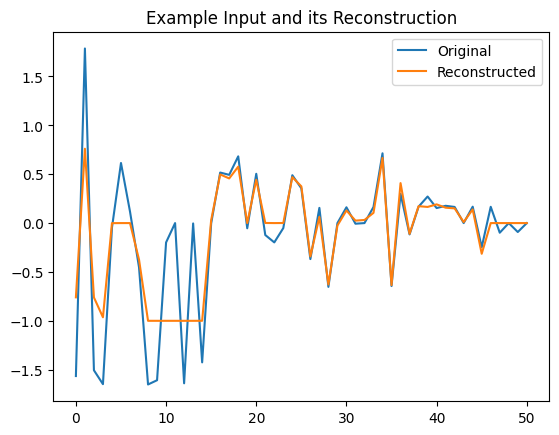

In [37]:
# Esempio di ricostruzione dei dati di test
encoded_data_test = autoencoder_model.encode(X_test_reshaped)
decoded_data_test = autoencoder_model.decode(encoded_data_test)

# Visualizzazione di un esempio di input e della sua ricostruzione
index = 0  # Puoi cambiare questo valore per visualizzare diverse istanze
plt.plot(X_test_reshaped[index], label='Original')
plt.plot(decoded_data_test[index], label='Reconstructed')
plt.legend()
plt.title("Example Input and its Reconstruction")
plt.show()


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dense, Flatten, Reshape, Concatenate
from tensorflow.keras.models import Model

def create_wide_deep_autoencoder(input_shape):
    # Wide branch
    wide_input = Input(shape=input_shape)
    wide_conv1 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(wide_input)
    wide_conv2 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(wide_conv1)
    wide_pooling = MaxPooling1D(pool_size=2)(wide_conv2)
    wide_flatten = Flatten()(wide_pooling)
    wide_dense = Dense(128, activation='relu')(wide_flatten)

    # Deep branch
    deep_input = Input(shape=input_shape)
    deep_conv1 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(deep_input)
    deep_conv2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(deep_conv1)
    deep_pooling = MaxPooling1D(pool_size=2)(deep_conv2)
    deep_flatten = Flatten()(deep_pooling)
    deep_dense = Dense(128, activation='relu')(deep_flatten)

    # Merge branches at latent code
    merged = Concatenate()([wide_dense, deep_dense])

    # Encoder
    encoder_output = Dense(64, activation='relu')(merged)

    # Decoder
    decoder_output = Dense(128, activation='relu')(encoder_output)
    decoder_output = Dense(input_shape[0] * input_shape[1], activation='sigmoid')(decoder_output)
    decoder_output = Reshape(input_shape)(decoder_output)

    # Autoencoder model
    autoencoder = Model(inputs=[wide_input, deep_input], outputs=decoder_output)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# Addestramento del modello
input_shape = X_train_reshaped.shape[1:]  # Forma dei dati di input
autoencoder_model = create_wide_deep_autoencoder(input_shape)
autoencoder_model.fit([X_train_reshaped, X_train_reshaped], X_train_reshaped, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
12615/12615 [==============================] - 90s 7ms/step - loss: 0.7267 - val_loss: 0.6960
Epoch 2/10
12615/12615 [==============================] - 77s 6ms/step - loss: 0.7224 - val_loss: 0.6932
Epoch 3/10
12615/12615 [==============================] - 77s 6ms/step - loss: 0.7214 - val_loss: 0.6932
Epoch 4/10
12615/12615 [==============================] - 76s 6ms/step - loss: 0.7214 - val_loss: 0.6932
Epoch 5/10
12615/12615 [==============================] - 79s 6ms/step - loss: 0.7213 - val_loss: 0.6932
Epoch 6/10
12615/12615 [==============================] - 76s 6ms/step - loss: 0.7213 - val_loss: 0.6933
Epoch 7/10
12615/12615 [==============================] - 76s 6ms/step - loss: 0.7213 - val_loss: 0.6932
Epoch 8/10
12615/12615 [==============================] - 76s 6ms/step - loss: 0.7213 - val_loss: 0.6931
Epoch 9/10
12615/12615 [==============================] - 77s 6ms/step - loss: 0.7213 - val_loss: 0.6932
Epoch 10/10
12615/12615 [==============================